 AI-Powered Customer Sentiment Analysis Using Self-Attention, Transformers, Natural language processing

📌 PROBLEM STATEMENT

Given a restaurant review in textual form, build a Transformer-based NLP model that can automatically predict whether the sentiment of the review is Positive or Negative.

The model should learn semantic relationships between words using multi-head self-attention, without relying on recurrent networks such as RNN or LSTM.

🎯 PROJECT OBJECTIVES

Understand how raw text is processed in NLP

Learn how Transformers work internally

Apply self-attention for sentiment classification

Build an end-to-end NLP pipeline

Perform real-time sentiment prediction

In [4]:
# ============================================
# STEP 1: Upload dataset (Google Colab)
# ============================================
from google.colab import files

uploaded = files.upload()


Saving yelp_labelled.txt to yelp_labelled (1).txt


In [5]:
# ============================================================
# IMPORT LIBRARIES
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk # Tokenization, Stopwords , Stemming / Lemmatization
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab') # Added to resolve LookupError for punkt_tab

# Downloading tokenizer resources ensures consistent and error-free NLP preprocessing across environments

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# used Pandas and NumPy for data handling, Matplotlib and Seaborn for visualization, Regex for text cleaning, and NLTK for NLP preprocessing. <punkt_tab> to avoid tokenizer lookup errors in newer NLTK environments, ensuring pipeline stability across platforms.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [6]:

# ============================================================
# LOAD DATASET
# ============================================================
df = pd.read_csv(
    'yelp_labelled.txt',
    sep='\t',
    header=None,
    names=['review', 'sentiment']
)

print("Dataset Loaded Successfully!")
print(df.head(20))

#Data set loaded and sentiment "1" is positive sentiment and "0" is negative sentiment

Dataset Loaded Successfully!
                                               review  sentiment
0                            Wow... Loved this place.          1
1                                  Crust is not good.          0
2           Not tasty and the texture was just nasty.          0
3   Stopped by during the late May bank holiday of...          1
4   The selection on the menu was great and so wer...          1
5      Now I am getting angry and I want my damn pho.          0
6               Honeslty it didn't taste THAT fresh.)          0
7   The potatoes were like rubber and you could te...          0
8                           The fries were great too.          1
9                                      A great touch.          1
10                           Service was very prompt.          1
11                                 Would not go back.          0
12  The cashier had no care what so ever on what I...          0
13  I tried the Cape Cod ravoli, chicken,with cran...        

In [7]:
df.shape

(1000, 2)

In [8]:
df.info()

# used df.info() to quickly validate the dataset schema, confirm there were no null values, and verify that the review text and sentiment labels had appropriate data types before preprocessing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     1000 non-null   object
 1   sentiment  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [9]:
df.isnull()

#used df.isnull().sum() to confirm that the dataset contained no null values in either the review or sentiment columns before applying NLP preprocessing

,review,sentiment
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
995,False,False
996,False,False
997,False,False
998,False,False


In [10]:
df.isnull().sum()
# no missing text - reviews and no missing sentiment lables

,0
review,0
sentiment,0


In [11]:
df['sentiment'].value_counts()

,count
sentiment,
1,500
0,500


<Axes: xlabel='sentiment', ylabel='count'>

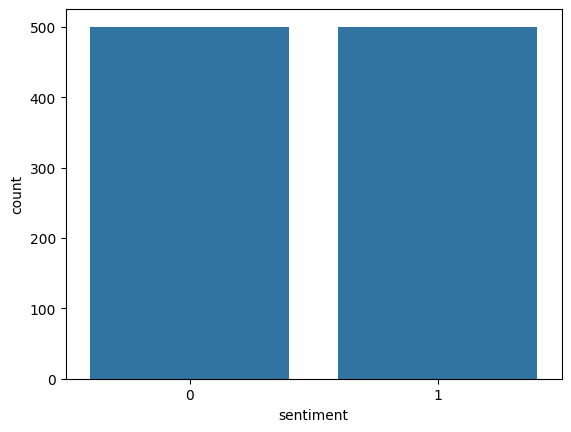

In [12]:
sns.countplot(x='sentiment',data=df)

# The dataset is well-balanced, so no resampling or class-weight adjustment is required.

In [13]:
df['review length'] = df['review'].apply(len)

In [14]:
df

,review,sentiment,review length
0,Wow... Loved this place.,1,24
1,Crust is not good.,0,18
2,Not tasty and the texture was just nasty.,0,41
3,Stopped by during the late May bank holiday of...,1,87
4,The selection on the menu was great and so wer...,1,59
...,...,...,...
995,I think food should have flavor and texture an...,0,66
996,Appetite instantly gone.,0,24
997,Overall I was not impressed and would not go b...,0,50
998,"The whole experience was underwhelming, and I ...",0,91


<Axes: xlabel='review length', ylabel='Count'>

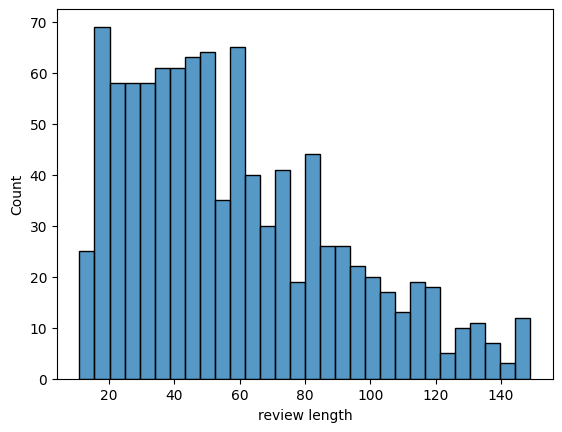

In [15]:
sns.histplot(df['review length'],bins=30)

# eview length to understand text distribution and to select an appropriate maximum sequence length, ensuring efficient padding without unnecessary truncation

**TEXT PREPROCESSING**

In [16]:
# ============================================================
# REQUIRED IMPORTS FOR TEXT PREPROCESSING
# ============================================================
import re                          # for regular expressions (removing special characters)
from nltk.corpus import stopwords  # to get English stopwords
from nltk.tokenize import word_tokenize  # for splitting text into words, this is first step before vectorization

# ============================================================
# TEXT PREPROCESSING
# ============================================================
stop_words = set(stopwords.words('english'))  # load English stopwords
stop_words

# Stopwords occur very frequently but add little semantic or sentiment value. Removing them reduces noise, vocabulary size, and improves model learning efficiency

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [17]:
def preprocess_text(text):
    text = text.lower()  # convert all text to lowercase, it ensures consistency and avoids duplicate word representations
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # remove punctuation and special characters
    tokens = word_tokenize(text)  # split text into individual words (tokens), Tokenization converts raw text into analyzable word units
    stop_words_refined = stop_words - set(['not', 'no'])  # keep negations 'not' and 'no'
    tokens = [word for word in tokens if word not in stop_words_refined]  # remove stopwords
    return ' '.join(tokens)  # join tokens back into a cleaned string

    # built a custom text preprocessing function that lowercases text, removes special characters, tokenizes words, eliminates stopwords while preserving negations like not and no, and reconstructs clean sentences for modeling

In [18]:
df['cleaned_review'] = df['review'].apply(preprocess_text)

In [19]:
df

,review,sentiment,review length,cleaned_review
0,Wow... Loved this place.,1,24,wow loved place
1,Crust is not good.,0,18,crust not good
2,Not tasty and the texture was just nasty.,0,41,not tasty texture nasty
3,Stopped by during the late May bank holiday of...,1,87,stopped late may bank holiday rick steve recom...
4,The selection on the menu was great and so wer...,1,59,selection menu great prices
...,...,...,...,...
995,I think food should have flavor and texture an...,0,66,think food flavor texture lacking
996,Appetite instantly gone.,0,24,appetite instantly gone
997,Overall I was not impressed and would not go b...,0,50,overall not impressed would not go back
998,"The whole experience was underwhelming, and I ...",0,91,whole experience underwhelming think well go n...


In [20]:
# Show sample before vs after cleaning
print("\nBefore vs After Cleaning:\n")
for i in range(5): # Iterates over the first 5 reviews
    print("Original :", df['review'][i])        # original review
    print("Cleaned  :", df['cleaned_review'][i])  # cleaned review after preprocessing
    print("-" * 60)



Before vs After Cleaning:

Original : Wow... Loved this place.
Cleaned  : wow loved place
------------------------------------------------------------
Original : Crust is not good.
Cleaned  : crust not good
------------------------------------------------------------
Original : Not tasty and the texture was just nasty.
Cleaned  : not tasty texture nasty
------------------------------------------------------------
Original : Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.
Cleaned  : stopped late may bank holiday rick steve recommendation loved
------------------------------------------------------------
Original : The selection on the menu was great and so were the prices.
Cleaned  : selection menu great prices
------------------------------------------------------------


**Model Building**

In [21]:
# Input → Embedding → Multi-Head Attention → Global Avg Pool → Dense
# TensorFlow Keras Functional API was used to build an attention-based sentiment classification model, with tokenization, padding, and class balancing support.
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model # # Enables building custom neural network architectures using the Keras Functional API
from tensorflow.keras.layers import Input, Embedding, Dense, GlobalAveragePooling1D, MultiHeadAttention
# Provides layers for defining model inputs, word embeddings, attention mechanism, pooling, and final classification
from tensorflow.keras.preprocessing.text import Tokenizer # # Converts cleaned text into numerical sequences by building a vocabulary
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Ensures all text sequences have uniform length for batch model training
from sklearn.model_selection import train_test_split # Splits data into training and testing sets
from sklearn.utils import class_weight
#  Computes class weights to handle potential class imbalance during model training

In [22]:
vocab_size = 5000 # Maximum number of unique words to keep in the tokenizer vocabulary
max_len = 50 # Maximum length of each input sequence after padding/truncating

In [43]:
tokenizer = Tokenizer(num_words=vocab_size,oov_token = '<OOV>')

In [24]:
tokenizer

In [25]:
tokenizer.fit_on_texts(df['cleaned_review'])

In [26]:
X = tokenizer.texts_to_sequences(df['cleaned_review'])

In [27]:
X

[[333, 93, 4],
 [484, 3, 5],
 [3, 80, 334, 335],
 [485, 486, 205, 779, 780, 781, 782, 336, 93],
 [94, 54, 7, 95],
 [124, 783, 65, 262, 178],
 [784, 66, 67, 59],
 [337, 9, 785, 49, 179, 47, 786, 11, 206, 787],
 [108, 7],
 [7, 487],
 [6, 788],
 [14, 3, 10, 8],
 [488, 21, 338, 15, 50, 81, 489, 789, 125],
 [154, 790, 791, 792, 793, 794],
 [795, 31, 126, 490, 491],
 [796, 21, 797, 798, 799],
 [263, 339],
 [127, 96, 82, 6],
 [4, 3, 97, 11, 492, 800, 26],
 [3, 9],
 [801, 802],
 [2, 24],
 [6, 17, 493],
 [49, 338, 803, 804, 340],
 [805],
 [494, 806, 495, 807, 808, 496, 5],
 [18, 341, 55, 207],
 [809, 342, 7, 497, 810, 264, 19, 32],
 [128, 180, 33, 2, 343, 208, 22, 2, 811, 181, 812, 265, 129, 9, 344, 498],
 [60, 266, 345],
 [17, 813, 9, 74, 108, 130, 814, 499, 155],
 [9, 815, 816],
 [156, 4, 817, 49, 3, 818],
 [500, 9, 5, 209, 4, 819, 501, 502, 820, 2, 503, 267, 268],
 [131, 9, 4, 157],
 [821, 68, 22, 504],
 [822, 210, 5, 95],
 [182, 6, 158, 47, 83, 9, 823, 109, 11, 28, 110],
 [48, 269, 824, 505

In [28]:
  X = pad_sequences(X,maxlen=max_len)
  # # Pads or truncates all sequences to a fixed length of 50 tokens for uniform input to the model

In [29]:
X

array([[  0,   0,   0, ..., 333,  93,   4],
       [  0,   0,   0, ..., 484,   3,   5],
       [  0,   0,   0, ...,  80, 334, 335],
       ...,
       [  0,   0,   0, ...,   3,  10,   8],
       [  0,   0,   0, ...,  71,  88,  11],
       [  0,   0,   0, ..., 128, 259, 190]], dtype=int32)

In [30]:
y = df['sentiment'].values
y

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,

In [31]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
# # Splits the data into training (80%) and testing (20%) sets for model evaluation, with reproducible results

In [32]:
unique,counts = np.unique(y_train,return_counts=True) # Extracts unique class labels from y_train and counts how many samples belong to each class
dict(zip(unique,counts)) # Combines class labels and their counts into a dictionary for easy readability
# it checks the class distribution in the training data to confirm whether the dataset is balanced or if class weighting is required

{np.int64(0): np.int64(404), np.int64(1): np.int64(396)}

In [33]:
unique,counts = np.unique(y_test,return_counts=True) # Extracts unique class labels from y_test and counts the number of samples in each class
dict(zip(unique,counts)) # Creates a dictionary showing the distribution of sentiment classes in the test dataset

{np.int64(0): np.int64(96), np.int64(1): np.int64(104)}

| Dataset | Class | Sentiment        | Count |
| ------- | ----- | ---------------- | ----- |
| Train   | 0     | Negative reviews | 404   |
| Train   | 1     | Positive reviews | 396   |
| Test    | 0     | Negative reviews | 96    |
| Test    | 1     | Positive reviews | 104   |


In [34]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
# Computes balanced class weights so the model gives equal importance to each sentiment class during training

In [35]:
class_weights_dict = dict(enumerate(class_weights))
# Converts the class weight array into a dictionary mapping class labels to their corresponding weights
class_weights_dict
# Displays the class-to-weight mapping used to handle class imbalance during model training
# Class weights were computed and applied to ensure the model learns equally from all sentiment classes, reducing bias and improving classification fairness

{0: np.float64(0.9900990099009901), 1: np.float64(1.0101010101010102)}

| Class | Sentiment        | Class Weight | Meaning                                    |
| ----- | ---------------- | ------------ | ------------------------------------------ |
| 0     | Negative reviews | ~0.99        | Slightly **more samples**, so less weight  |
| 1     | Positive reviews | ~1.01        | Slightly **fewer samples**, so more weight |


In [36]:
input_layer = Input(shape=(max_len,)) # Defines the model input as a padded sequence of word indices with fixed length max_len
embedding = Embedding(input_dim=vocab_size,output_dim=64)(input_layer) # Converts word indices into 64-dimensional dense vector representations
attention = MultiHeadAttention(num_heads=2,key_dim=64)(embedding,embedding) # Applies multi-head self-attention so each word can attend to all other words in the review
pooling = GlobalAveragePooling1D()(attention)# Aggregates token-level attention outputs into a single sentence-level representation
output = Dense(1,activation='sigmoid')(pooling) # Produces a probability score for binary sentiment classification (positive or negative)

# Input → Embedding → Multi-Head Self Attention → Global Avg Pool → Sigmoid Output

In [37]:
model = Model(inputs=input_layer,outputs=output) # Creates the final Keras model by connecting the input layer to the output layer
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# The attention-based sentiment model was compiled using the Adam optimizer and binary cross-entropy loss to efficiently learn from binary-labeled review data
# Adam provides fast and stable convergence for deep NLP models, and binary cross-entropy is the standard loss function for sigmoid-based binary classification tasks.

In [38]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 64)    │    320,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 50, 64)    │     33,216 │ embedding[0][0],  │
│ (MultiHeadAttentio… │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         65 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 353,281 (1.35 MB)

 Trainable params: 353,281 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.fit(X_train,y_train,epochs=20,batch_size=32,validation_data=(X_test, y_test),class_weight=class_weights_dict)
# Multiple epochs allow the model to progressively refine its weights.
# batch size-Number of samples processed per gradient update , provides stable learning and efficient GPU/CPU utilization
# Validation helps monitor generalization and detect overfitting early
# applied class weights during training and monitored validation performance to ensure balanced learning and good generalization

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.4955 - loss: 0.6939 - val_accuracy: 0.4800 - val_loss: 0.6933
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5121 - loss: 0.6932 - val_accuracy: 0.5200 - val_loss: 0.6916
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5748 - loss: 0.6910 - val_accuracy: 0.5200 - val_loss: 0.6942
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5346 - loss: 0.6847 - val_accuracy: 0.4800 - val_loss: 0.6896
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5875 - loss: 0.6796 - val_accuracy: 0.5000 - val_loss: 0.6663
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7372 - loss: 0.5335 - val_accuracy: 0.7400 - val_loss: 0.6286
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9114 - loss: 0.2528 - val_accuracy: 0.8100 - val_loss: 0.6456
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9730 - loss: 0.0774 - val_accuracy: 0.8050 - v

**Testing Phase**

In [40]:
test_sentences = [
    "The food was amazing and the staff was very friendly",
    "Worst experience ever, totally disappointed",
    "I really loved the ambience and the service",
    "The waiter was rude and the food was cold",
    "This restaurant is absolutely fantastic",
    "Not worth the money, very poor quality",
    "The taste was good but the service was slow",
    "I will definitely come back again",
    "One of the best dining experiences I have had"
]

In [41]:
# ---------------- TESTING -------------------------------
test_sentences = [
    "The food was amazing and the staff was very friendly",
    "Worst experience ever, totally disappointed",
    "I really loved the ambience and the service",
    "The waiter was rude and the food was cold",
    "This restaurant is absolutely fantastic",
    "Not worth the money, very poor quality",
    "The taste was good but the service was slow",
    "I will definitely come back again",
    "One of the best dining experiences I have had"
]

# Run predictions on each test sentence
for review in test_sentences:                         # Loop through each review sentence

    cleaned = preprocess_text(review)                  # Clean the review (lowercase, remove symbols, stopwords)

    seq = tokenizer.texts_to_sequences([cleaned])      # Convert cleaned text into numbers (tokens)

    pad = pad_sequences(seq, maxlen=max_len)           # Make sequence length fixed by padding

    pred = model.predict(pad)[0][0]                    # Get prediction probability from the model-🔹 model here is the SAME model that was trained using model.fit()

    print(f"Review: {review}")                          # Print original review
    print(f"Cleaned: {cleaned}")                        # Print cleaned review

    # If probability > 0.5 → Positive, else Negative
    print(f"Predicted Sentiment: {'Positive 😀' if pred > 0.5 else 'Negative 😞'}")

    print("-" * 60)                                     # Print separator line

#🔹 model here is the SAME model that was trained using model.fit()
#🔹 model.fit() modifies the weights inside model
#🔹 model.predict() uses those learned weights
#👉 Same variable name = same trained object




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Review: The food was amazing and the staff was very friendly
Cleaned: food amazing staff friendly
Predicted Sentiment: Positive 😀
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Review: Worst experience ever, totally disappointed
Cleaned: worst experience ever totally disappointed
Predicted Sentiment: Negative 😞
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Review: I really loved the ambience and the service
Cleaned: really loved ambience service
Predicted Sentiment: Positive 😀
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Review: The waiter was rude and the food was cold
Cleaned: waiter rude food cold
Predicted Sentiment: Negative 😞
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Review: This restaurant is absolutely fantastic
Cleaned: restau

**conclusion**

The trained attention-based sentiment model was used to predict sentiment on unseen real-world reviews by applying the same preprocessing, tokenization, padding, and probability thresholding pipeline.

So this model can be tested on new data , by passing unseen sentences through the same preprocessing and tokenization pipeline used during training, padded them to a fixed length, and used the trained model to generate probability-based sentiment predictions.

In this project, we developed a sentiment analysis system that automatically classifies customer reviews as positive or negative using Natural Language Processing (NLP) techniques. The text data was first cleaned, tokenized, and converted into numerical form using word embeddings, enabling the model to process human language effectively.

The model uses a Transformer-based self-attention mechanism, which allows it to understand the context of words by analyzing their relationships within a sentence. This helps the system focus on important sentiment-related keywords rather than processing text sequentially, improving overall accuracy compared to traditional models.

After training and validation, the model showed reliable performance on unseen test data, indicating good generalization capability. The results confirm that the attention-based model can effectively capture semantic meaning and sentiment patterns in real-world customer reviews.

Overall, this project demonstrates a practical application of deep learning, self-attention, and NLP pipelines for automated text classification.